## Graphical difference between two files

`py_ncdiff.py` contains a class that lets you read in two netCDF files and run a range of tests to determine whether they are the same or not. This notebook builds on that by providing a mechanism to plot differences in fields that are found in both files.

In [1]:
# Import necessary modules
import py_ncdiff
import os
import logging
import numpy as np

# Setup logging so info / debug -> stdout instead of stderr
py_ncdiff.init_logging()
logger = logging.getLogger(__name__)

#### Read netCDF files

This next cell determines what files to read in. It's currently configured to compare two history files from on Cheyenne.

In [2]:
baseline_case = 'C1850ECO.T62_g37.ciso.trunk_20180716'
new_case = 'C1850ECO.T62_g37.ciso.trunk_20180705'

root_dir = os.path.join(os.path.sep,'glade','scratch_new','mlevy')
if not os.path.isdir(root_dir):
    root_dir = os.path.join(os.path.sep,'sshfs') + root_dir
    if not os.path.isdir(root_dir):
        logger.error("Can not find root directory (may need to mount sshfs drive)")

baseline = os.path.join(root_dir,'baselines','single_run',baseline_case+'.pop.h.0001-01-03.nc')
new_file = os.path.join(root_dir,new_case,'run',new_case+'.pop.h.0001-01-03.nc')

for filename in [baseline, new_file]:
    if not os.path.isfile(filename):
        logger.error("File not found: {}".format(filename))

if os.path.isfile(baseline) and os.path.isfile(new_file):
    nc_test = py_ncdiff.netCDF_comp_class(baseline=baseline, new_file=new_file, quiet=True, is_POP=True)

Comparing /sshfs/glade/scratch_new/mlevy/baselines/single_run/C1850ECO.T62_g37.ciso.trunk_20180716.pop.h.0001-01-03.nc and /sshfs/glade/scratch_new/mlevy/C1850ECO.T62_g37.ciso.trunk_20180705/run/C1850ECO.T62_g37.ciso.trunk_20180705.pop.h.0001-01-03.nc
-----
Baseline modified: Thu Jul 19 11:08:57 2018
New file modified: Thu Jul 19 11:43:37 2018
-----


#### Run the comparison tests?

I don't think it's necessary to run the tests here (and they can be a bit time-consuming)... but there's no reason the test results can't be displayed in this notebook if desired.

In [3]:
# Set to true if you want to run the tests in this notebook
run_tests = False

if run_tests:
    nc_test.compare_variable_names()
    nc_test.compare_variable_type_and_dims()
    nc_test.compare_metadata()
    nc_test.compare_values()
    err_cnt = nc_test.parse_results()

#### Plot differences

I think the easiest way to these plots is to define a function that takes a variable name in and produces the plots if the variable exists in both datasets.

In [4]:
def make_plots(var_to_plot):
    """
    This function checks to see if var_to_plot exists in both nc_test.baseline['ds'] and nc_test.new_file['ds'].
    
    Returns True if plots were successfully made; returns False if var_to_plot is not found in both datasets
    """
    # Set up modules for plotting
    import matplotlib.ticker
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    %matplotlib inline

    # Set up logger
    logger = logging.getLogger(__name__)

    # Only continue if variable is in both datasets
    if var_to_plot not in nc_test.common_vars:
        logger.error("{} can not be found in both datasets".format(var_to_plot))
        return False

    da_baseline = nc_test.baseline['ds'][var_to_plot]
    da_new_file = nc_test.new_file['ds'][var_to_plot]

    # (kwargs will look only at surface for 3D fields)
    kwargs = dict()
    kwargs['time']=0
    if 'z_t' in da_baseline.coords:
        kwargs['z_t']=0

    # compute difference between the two variables
    # Note that it is possible that there are differences in TLAT and / or TLON between the two files
    # (E.g. comparing history files from different compilers or different machines)
    # If that is a small difference, we just use the baseline variable, otherwise return ERROR
    da_diff = da_new_file - da_baseline
    for coord in ['TLAT', 'TLONG']:
        if coord not in da_diff.coords:
            max_diff = np.amax(np.abs(nc_test.baseline['ds'][coord].data) - np.abs(nc_test.new_file['ds'][coord].data))
            if max_diff < 1e-8:
                da_diff.coords[coord] = nc_test.baseline['ds'][coord]
            else:
                logger.error('{} differs by at most {} between baseline and new file'.format(coord, max_diff))
                return False

    # Compute min and max for contours
    glo_min = np.min([np.amin(da_baseline), np.amin(da_new_file)])
    glo_max = np.max([np.amax(da_baseline), np.amax(da_new_file)])

    # Should difference contours be centered around 0?
    diff_contours_centered_0 = True
    if diff_contours_centered_0:
        diff_max = np.amax(np.abs(da_diff))
        diff_min = -diff_max
    else:
        diff_min = np.amin(da_diff)
        diff_max = np.amax(da_diff)

    # Two panels of fig1 (left is baseline, right is new_file)
    fig1, (ax1, ax2)=plt.subplots(nrows=1, ncols=2, figsize=(10,2.5), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=141), sharey=True))
    img1 = da_baseline.isel(**kwargs).plot.pcolormesh(ax=ax1, x='TLONG', y='TLAT', vmin=glo_min, vmax=glo_max, cmap='RdBu_r', transform=ccrs.PlateCarree());
    img1.colorbar.remove()
    img2 = da_new_file.isel(**kwargs).plot.pcolormesh(ax=ax2, x='TLONG', y='TLAT', vmin=glo_min, vmax=glo_max, cmap='RdBu_r', transform=ccrs.PlateCarree());
    img2.colorbar.remove()
    plt.tight_layout()

    # Single panel for fig2 (just showing difference)
    fig2, ax3 = plt.subplots(figsize=(5,2.5), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=141)))
    img3 = da_diff.isel(**kwargs).plot.pcolormesh(ax=ax3, x='TLONG', y='TLAT', vmin=diff_min, vmax=diff_max, cmap='RdBu_r', transform=ccrs.PlateCarree());
    img3.colorbar.remove()
    plt.tight_layout()

    # Colorbar at bottom
    cax1 = fig1.add_axes([0.1, -0.075, 0.815, 0.05])
    cb = fig1.colorbar(img1, cax=cax1, orientation='horizontal')

    cax2 = fig2.add_axes([0.05, -0.05, 0.95, 0.025])
    cb2 = fig2.colorbar(img3, cax=cax2, orientation='horizontal')
    cb2.locator = matplotlib.ticker.MaxNLocator(nbins=5)
    cb2.update_ticks()

    # Update titles and add coast lines
    ax1.coastlines()
    ax1.set_title("{}: Baseline values".format(var_to_plot))
    ax2.coastlines()
    ax2.set_title("{}: New file values".format(var_to_plot))
    ax3.coastlines()
    ax3.set_title("{}: New file values - Baseline values".format(var_to_plot))
    
    return True

#### Pick a variable

Set `var_to_plot` to the name of the variable you would like to plot; `make_plots()` will return an error if it does not exist otherwise it will draw plots.

Units of SSH: centimeter


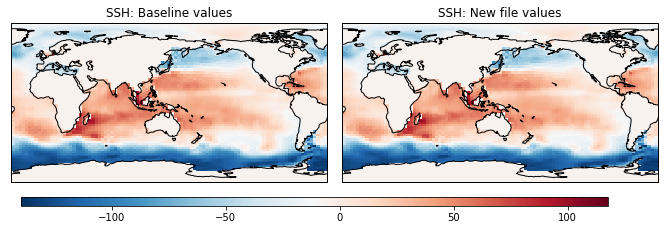

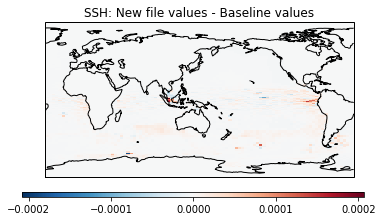

In [5]:
# Pick variable to plot
var_to_plot = 'SSH'

# Make plots and then print units of var_to_plot
if make_plots(var_to_plot):
    print("Units of {}: {}".format(var_to_plot, nc_test.baseline['ds'][var_to_plot].attrs['units']))